In [1]:
SEED_NUMBER = 1234
from numpy.random import seed
from tensorflow.compat.v1 import set_random_seed
seed(SEED_NUMBER)
set_random_seed(SEED_NUMBER)

import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import seaborn as sns

import shutil
import pathlib
import tempfile

LOGDIR = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(LOGDIR, ignore_errors=True)

pd.options.display.max_columns=500
pd.options.display.max_rows=500

# load preprocessed datasets
train = pd.read_csv('./data/processed/train_processed.csv')  
test = pd.read_csv('./data/processed/test_processed.csv') 

#### Preprocess: 
See task/process_data.py and Data Processing README.rmd for detailed documentation.
- remove outliers
- impute missing values
- add new features
- dummify categorical features
- bucketize numeric features and dummified

In [2]:
print(train.shape)
print(train.isnull().sum().sum()) # check for no missing value
train.head() # visually inspect dataset. 

(1456, 258)
0


,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinType1,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,IsPool,IsGarage,IsFireplace,TotalFullBath,TotalHalfBath,TotalSF,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,65.0,8450,7,5,196.0,8,6,8,6,10,706,0,150,856,10,856,854,0,1710,1,0,2,1,3,1,8,8,0,0,2003.0,4,2,548,6,6,0,61,0,0,0,0,0,208500,0,1,1,3,1,2566,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,

<b> Standard Scaler</b>
<br>
Scaling numeric features helps with model in general.
This is proven to improve neural networks model performance.

In [3]:
# numeric columns where values range beyond -1 to 1.
SCALE_COLS = ['BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'GarageYrBlt', 'OpenPorchSF', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtFinSF1', 'BsmtFinSF2', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'FireplaceQu',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'WoodDeckSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'TotalFullBath', 'TotalHalfBath', 'TotalSF', 'HeatingQC','BsmtFinType1']


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # default : copy=True, with_mean=True, with_std=True
scaler.fit(train[SCALE_COLS]) # we can save scaler if need to be reused in the future or build it into our data preprocessing pipeline.

# transform
train_s = pd.DataFrame(scaler.transform(train[SCALE_COLS]), columns = SCALE_COLS)
train_s = pd.concat([train.drop(columns=SCALE_COLS).reset_index(drop=True),train_s],axis=1)

test_s = pd.DataFrame(scaler.transform(test[SCALE_COLS]), columns = SCALE_COLS)
test_s = pd.concat([test.drop(columns=SCALE_COLS).reset_index(drop=True),test_s], axis=1)

print(f'training shape: {train_s.shape} and test shape: {test.shape}')
test_s.head() # check that scaler worked.

training shape: (1456, 258) and test shape: (1459, 257)


,IsPool,IsGarage,IsFireplace,IsOpenPorch,YrBuilt_1929,YrBuilt_1954,YrBuilt_1963,YrBuilt_1973,YrBuilt_1990,YrBuilt_2000,YrBuilt_2005,YrBuilt_2009,YrRemodAdd_1929,YrRemodAdd_1954,YrRemodAdd_1963,YrRemodAdd_1973,YrRemodAdd_1990,YrRemodAdd_2000,YrRemodAdd_2005,YrRemodAdd_2009,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Condition1_Norm,Condition1_Other,LotShape_Artery,LotShape_Feedr,LotShape_Norm,LotShape_PosA,LotShape_PosN,LotShape_RRAe,LotShape_RRAn,LotShape_RRNn,Functional_IReg,Functional_Reg,Electrical_N,RoofMatl_Other,RoofMatl_SBrkr,RoofStyle_CompShg,RoofStyle_Other,Heating_Gable,Heating_Hip,Heating_Other,Foundation_GasA,Foundation_Other,SaleType_BrkTil,SaleType_CBlock,SaleType_Other,SaleType_PConc,LandContour_COD,LandContour_New,LandContour_Other,LandContour_WD,MSZoning_Bnk,MSZoning_HLS,MSZoning_Low,MSZoning_Lvl,Street_C (all),Street_FV,Street_RH,Street_RL,Street_RM,Alley_Grvl,Alley_Pave,HouseStyle_Grvl,HouseStyle_None,HouseStyle_Pave,BldgType_1.5Fin,BldgType_1.5Unf,BldgType_1Story,BldgType_2.5Fin,BldgType_2.5Unf,BldgType_2Story,BldgType_SFoyer,BldgType_SLvl,LandSlope_1Fam,LandSlope_2fmCon,LandSlope_Duplex,LandSlope_Twnhs,LandSlope_TwnhsE,LotConfig_Gtl,LotConfig_Mod,LotConfig_Sev,Neighborhood_Corner,Neighborhood_CulDSac,Neighborhood_FR2,Neighborhood_FR3,Neighborhood_Inside,GarageType_Blmngtn,GarageType_Blueste,GarageType_BrDale,GarageType_BrkSide,GarageType_ClearCr,GarageType_CollgCr,GarageType_Crawfor,GarageType_Edwards,GarageType_Gilbert,GarageType_IDOTRR,GarageType_MeadowV,GarageType_Mitchel,GarageType_NAmes,GarageType_NPkVill,GarageType_NWAmes,GarageType_NoRidge,GarageType_NridgHt,GarageType_OldTown,GarageType_SWISU,GarageType_Sawyer,GarageType_SawyerW,GarageType_Somerst,GarageType_StoneBr,GarageType_Timber,GarageType_Veenker,PavedDrive_2Types,PavedDrive_Attchd,PavedDrive_Basment,PavedDrive_BuiltIn,PavedDrive_CarPort,PavedDrive_Detchd,PavedDrive_None,Fence_N,Fence_P,Fence_Y,MasVnrType_GdPrv,MasVnrType_GdWo,MasVnrType_MnPrv,MasVnrType_MnWw,MasVnrType_None,CentralAir_BrkCmn,CentralAir_BrkFace,CentralAir_None,CentralAir_Stone,SaleCondition_N,SaleCondition_Y,BsmtExposure_Abnorml,BsmtExposure_AdjLand,BsmtExposure_Alloca,BsmtExposure_Family,BsmtExposure_Normal,BsmtExposure_Partial,Condition2_Av,Condition2_Gd,Condition2_Mn,Condition2_No,Condition2_None,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,GarageYrBlt,OpenPorchSF,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,WoodDeckSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,TotalFullBath,TotalHalfBath,TotalSF,HeatingQC,BsmtFinType1
0,0,1,1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [4]:
# convert datatypes
train_labels = np.array(train_s.pop('SalePrice'))
train_s = np.asarray(train_s)
test_s = np.asarray(test_s)

<b>Benchmark model</b>
<br>Establishing a simple linear model with L1 regularization as our benchmark model to compare our neural net models against.

In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

lasso = Lasso()
alpha_range = [0.0003, 0.03, 0.3, 3, 33, 333, 3333]
grid = GridSearchCV(lasso, {'alpha':alpha_range}, scoring = 'neg_root_mean_squared_error', cv =3)

grid.fit(train_s, train_labels)
print(grid.best_params_)
print(-1*grid.best_score_)

/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 297584767313.9336, tolerance: 623449476.7675469
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 279902865896.9026, tolerance: 590880064.7639043
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 302168937268.6676, tolerance: 626355690.1012101
  positive)
/Users/melaniezheng/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did 

{'alpha': 333}
29544.774225841018


<b> Benchmark model: LASSO w/ alpha = 333. </b>
- Cross Valiation mean RMSE: 29,544.
- this alpha represents a very big penalization for large coefficients. 

## Neural Network - Keras

Starting from the simplest, let's start with basic nn with only 1 hidden unit.
<br>
X --> 257 (Relu) --> Y, dim(X) = [1081, 257]
<br>
optimizers: 
- keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
- keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow.keras.models import load_model
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2) # plotting training progress history
CHECKPOINT_PATH = './model_checkpoints/'

### build simple model

In [7]:
def simple_model():
    # build a basic neural net model: X--> 257 --> Y
    model = keras.Sequential()
    model.add(layers.Dense(train_s.shape[1], activation='relu', input_shape=[train_s.shape[1],]))
    model.add(layers.Dense(1))
    # model.summary()
    return model

In [8]:
def compile_and_fit(model, X, y, max_epochs, batchsize, optimizer):
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    set_random_seed(SEED_NUMBER) # reproducibility
    history = model.fit(X, y, epochs = max_epochs, batch_size = batchsize, verbose = 0)
    return history

def compile_and_fit_early_stopping(model, X, y, max_epochs, 
                                   batchsize, optimizer, patience, checkpoint_path):
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode = 'min')
    check_point = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor = 'val_loss', 
                                                  save_best_only = True, mode = 'min')
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [keras.metrics.RootMeanSquaredError()])
    
    set_random_seed(SEED_NUMBER) # reproducibility
    history = model.fit(X, y, epochs = max_epochs, validation_split = 0.2,
                        batch_size = batchsize, verbose = 0,
                        callbacks=[early_stop, check_point])
    return history

### Define cross validation metrics

In [9]:
from tensorflow.keras.models import clone_model
def get_cv_scores(estimator, max_epochs = 10, batchsize = 32, 
                  optimizer = keras.optimizers.RMSprop(0.01)):
    cvscores = []
    histories = []
    kf = KFold(3, shuffle=True, random_state = SEED_NUMBER)
    for tr, val in kf.split(train_s, train_labels):
        set_random_seed(SEED_NUMBER) # reproducibility
        model = clone_model(estimator) # create model
        history = compile_and_fit(model, train_s[tr], train_labels[tr], max_epochs, batchsize, optimizer)
        histories.append(history)
        scores = model.evaluate(train_s[val], train_labels[val], verbose=0)
        cvscores.append(scores[1])
    print("CV Score: %.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))
    return (histories, cvscores)

In [10]:
def plot_histories(histories):
    for history in histories:
        hist = pd.DataFrame(history.history) 
        hist['epoch'] = history.epoch
        sns.lineplot(x='epoch',y='root_mean_squared_error', data=hist)
    
def plot_histories_with_names(histories_lst, names):
    # plots average root mean squared error from 3 fold cv.
    
    # names : repeat each element 3 times (for cross validation) [1,2,3] --> [1,1,1,2,2,2,3,3,3] 
    names = [item for sublist in [[name]*3 for name in names] for item in sublist]
    histories_lst = [history for histories in histories_lst for history in histories] # flatten
    df = pd.DataFrame(columns=['loss','root_mean_squared_error','epoch','name'])
    for history, name in zip(histories_lst, names):
        hist = pd.DataFrame(history.history) 
        hist['epoch'] = history.epoch
        hist['name'] = name
        df = df.append(hist)
    df = df.groupby(['name','epoch']).mean()[['root_mean_squared_error']].reset_index()
    plt.figure(figsize=(12,5))
    sns.lineplot(x='epoch',y='root_mean_squared_error', data=df, hue = 'name')

<b> Try Simple Model

CV Score: 28407.41 (+/- 401.49)


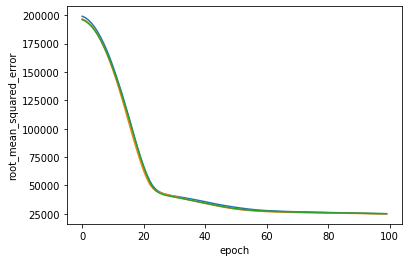

In [11]:
estimator = simple_model()
histories, cvscores = get_cv_scores(estimator, max_epochs = 100)
plot_histories(histories)

As you see from above, simple neural net is already performing better than the fine tuned lasso model.
<br>
Let's tune some parameters to see if we can achieve a better model.

### Tuning Optimizer

#### Learning rate
let's try other learning rate to see if see if we can furture improve simple neural net

CV Score: 166559.17 (+/- 2487.31)
CV Score: 28407.41 (+/- 401.49)
CV Score: 26316.27 (+/- 101.46)
CV Score: 26627.12 (+/- 252.16)


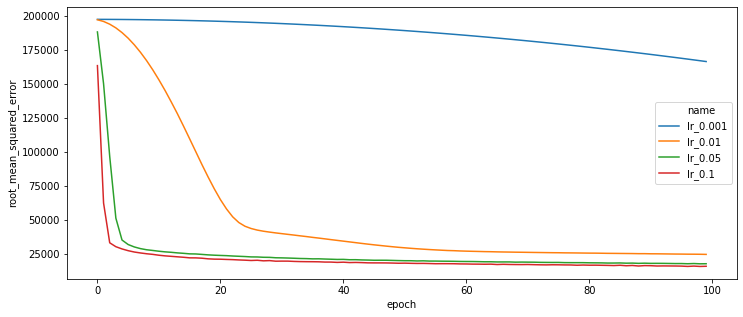

In [12]:
histories_lst = []
lr_range = [0.001, 0.01, 0.05, 0.1]
for lr in lr_range:
    optimizer = keras.optimizers.RMSprop(lr)
    estimator = simple_model()
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = 100)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['lr_'+str(lr) for lr in lr_range])

- 0.001 converges too slow and training takes very long
- 0.05 and 0.1 are not as good as Keras default learning rate 0.01 for our dataset.
<br> Let's try another popular optimizer, Adam

<b>Adam optimizer</b>

CV Score: 116659.26 (+/- 16091.62)
CV Score: 27364.61 (+/- 466.83)
CV Score: 26163.41 (+/- 253.59)
CV Score: 27138.13 (+/- 486.53)


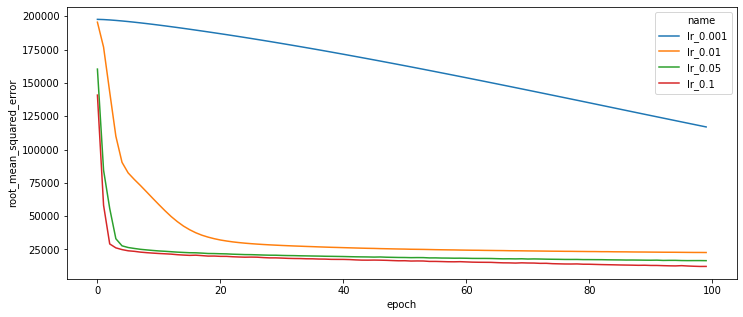

In [13]:
histories_lst = []
lr_range = [0.001, 0.01, 0.05, 0.1]
for lr in lr_range:
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,amsgrad=False)
    model = simple_model()
    histories, cvscores = get_cv_scores(model, optimizer = optimizer, max_epochs = 100)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['lr_'+str(lr) for lr in lr_range])

- For our dataset, ADAM with 0.05 learning rate is preforming better for the basic neural net. 

### Epochs and Batch Size

__Manually Tune Epochs__

In [14]:
for ep in range(30, 100, 10):
    optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
    model = simple_model()
    print('- '*20+'EPOCH: '+str(ep)+' -'*20)
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = ep)

- - - - - - - - - - - - - - - - - - - - EPOCH: 30 - - - - - - - - - - - - - - - - - - - -
CV Score: 26888.86 (+/- 117.58)
- - - - - - - - - - - - - - - - - - - - EPOCH: 40 - - - - - - - - - - - - - - - - - - - -
CV Score: 26504.40 (+/- 73.32)
- - - - - - - - - - - - - - - - - - - - EPOCH: 50 - - - - - - - - - - - - - - - - - - - -
CV Score: 26256.51 (+/- 56.23)
- - - - - - - - - - - - - - - - - - - - EPOCH: 60 - - - - - - - - - - - - - - - - - - - -
CV Score: 26305.68 (+/- 113.48)
- - - - - - - - - - - - - - - - - - - - EPOCH: 70 - - - - - - - - - - - - - - - - - - - -
CV Score: 26057.14 (+/- 72.72)
- - - - - - - - - - - - - - - - - - - - EPOCH: 80 - - - - - - - - - - - - - - - - - - - -
CV Score: 26115.56 (+/- 21.41)
- - - - - - - - - - - - - - - - - - - - EPOCH: 90 - - - - - - - - - - - - - - - - - - - -
CV Score: 26153.97 (+/- 90.34)


- EPOCHS = 70 gives us best cross validation scores, however we only tried 30, 40, 50, 60, 70, 80, 90 epochs.

__Early Stopping__

In [15]:
estimator = simple_model()
optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
checkpoint_path = CHECKPOINT_PATH + 'simple/early_stopping.h5'
history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                         batchsize=32, optimizer = optimizer, 
                                         patience = 20, checkpoint_path = checkpoint_path)
best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
print(f'Best Early Stop Epoch: {best_epoch}')

model = simple_model()
histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch, batchsize = 32)

Best Early Stop Epoch: 61
CV Score: 25991.97 (+/- 87.26)


- using early stopping to help us pick the optimum epochs seems to be a solid strategy.
However, there is a parameter, __patience__ we should tune to see which will give us optimum result.

__batch size__

Mini-batch sizes, commonly called “batch sizes” for brevity, are often tuned to an aspect of the computational architecture on which the implementation is being executed. 
<br>- Small values give a learning process that converges quickly at the cost of noise in the training process.
<br>- Large values give a learning process that converges slowly with accurate estimates of the error gradient.

Such as a power of two that fits the memory requirements of the GPU or CPU hardware like 32, 64, 128, 256, and so on. Since we only have ~1400 training samples, let's try batch size 16, 32, 64, 128.

- - - - - - - - - - - - - - - - - - - - Batch Size: 16 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 41
CV Score: 25867.46 (+/- 124.91)
- - - - - - - - - - - - - - - - - - - - Batch Size: 32 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 61
CV Score: 25991.97 (+/- 87.26)
- - - - - - - - - - - - - - - - - - - - Batch Size: 64 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 116
CV Score: 26244.98 (+/- 126.85)
- - - - - - - - - - - - - - - - - - - - Batch Size: 128 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 223
CV Score: 26227.74 (+/- 331.54)


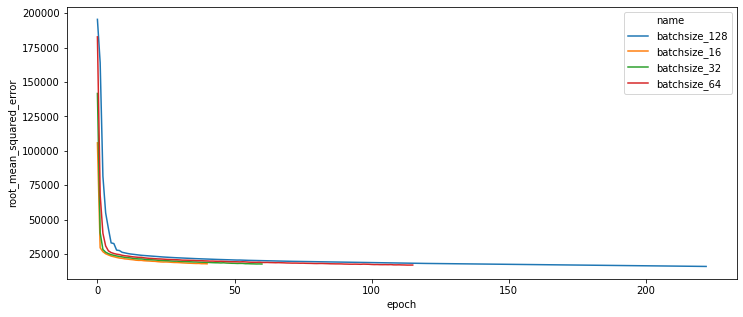

In [16]:
histories_lst = []
bs_range = [16, 32, 64, 128]
for bs in bs_range:
    print('- '*20 + 'Batch Size: ' + str(bs) + ' -'*20)
    optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
    estimator = simple_model()
    

    checkpoint_path = CHECKPOINT_PATH + 'simple/try_batch_size_' + str(bs) + '.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                             batchsize=bs, optimizer = optimizer, 
                                             patience = 20, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Best Early Stop Epoch: {best_epoch}')
    
    estimator = simple_model()
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, 
                                        max_epochs = best_epoch, batchsize = bs)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['batchsize_'+str(bs) for bs in bs_range])

- batch size 16 works well for the simple model for our dataset.

- using early stopping to help us pick the optimum epochs seems to be a solid strategy.
However, there is a parameter, __patience__ we should tune to see which will give us optimum result.

In [17]:
for p in range(10, 60, 10):
    print('- '*10 + 'Patience: ' + str(p)+ ' -'*20)
    estimator = simple_model()
    optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + f'simple/simple_patience{p}.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                             batchsize=16, optimizer = optimizer, 
                                             patience = p, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Best Early Stop Epoch: {best_epoch}')

    model = simple_model()
    histories, cvscores = get_cv_scores(model, optimizer = optimizer, max_epochs = best_epoch, batchsize = 16)
    
    

- - - - - - - - - - Patience: 10 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 41
CV Score: 25864.83 (+/- 132.48)
- - - - - - - - - - Patience: 20 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 41
CV Score: 25867.46 (+/- 124.91)
- - - - - - - - - - Patience: 30 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 41
CV Score: 25864.59 (+/- 123.97)
- - - - - - - - - - Patience: 40 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 41
CV Score: 25861.82 (+/- 123.55)
- - - - - - - - - - Patience: 50 - - - - - - - - - - - - - - - - - - - -
Best Early Stop Epoch: 41
CV Score: 25862.42 (+/- 126.87)


In [18]:
model = load_model('./model_checkpoints/simple/simple_patience40.h5') # load check point model
histories, cvscores = get_cv_scores(model, optimizer = optimizer, max_epochs = 41, batchsize = 16)
compile_and_fit(model, train_s, train_labels, 41, 16, optimizer)
model.save('./model/best_simple_model') # save model

CV Score: 25864.60 (+/- 123.64)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./model/best_simple_model/assets



<br>Next, let's try new models with hidden layer neuron size bigger and small to see if that help our model perform better.

### Narrower/Wider Models
Recall our basic nn model (X -> 257 -> Y). Let's try other number of neurons other than 257.
<br>
Based on research, good rule of thumbs for N are: 2, (257 + 1)/ 2=129, we can also try some other numbers, 10, 50, 80, 160, 320, 500.

In [19]:
def wider_narrower_model(N, dropout = False, rate = 0.15):
    model = keras.Sequential()
    model.add(layers.Dense(N, activation='relu', input_shape=[train_s.shape[1],]))
    if dropout:
            model.add(layers.Dropout(rate, seed = SEED_NUMBER))
    model.add(layers.Dense(1))
    # model.summary()
    return model

__optimize Epochs using Early Stopping__



- - - - - - - - - - - - - - - - - - - - No. of Neurons: 2 - - - - - - - - - - - - - - -

Early Stop Epoch: 230
CV Score: 29241.01 (+/- 572.76)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 10 - - - - - - - - - - - - - - -

Early Stop Epoch: 315
CV Score: 26672.60 (+/- 209.78)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 50 - - - - - - - - - - - - - - -

Early Stop Epoch: 157
CV Score: 26189.44 (+/- 147.32)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 80 - - - - - - - - - - - - - - -

Early Stop Epoch: 135
CV Score: 26198.00 (+/- 181.33)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 129 - - - - - - - - - - - - - - -

Early Stop Epoch: 97
CV Score: 26268.25 (+/- 228.08)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 160 - - - - - - - - - - - - - - -

Early Stop Epoch: 79
CV Score: 26133.86 (+/- 208.50)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 320 - - - - - - - - - - - - - - -

Early Stop Epoch: 47
CV Score: 2

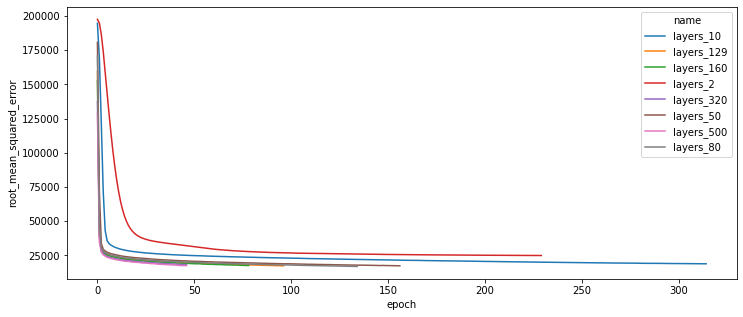

In [20]:
histories_lst=[]
neuron_sizes = [2, 10, 50, 80, 129, 160, 320, 500]
for N in neuron_sizes:
    print('\n')
    print('- '*20+'No. of Neurons: '+str(N)+' -'*15 + '\n')
    estimator = wider_narrower_model(N)
    optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + str(N) + '.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=32, optimizer = optimizer, patience = 20, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    estimator = wider_narrower_model(N)
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['layers_'+str(N) for N in neuron_sizes])

### Adding Dropout
Dropout refers to ignoring neurons during the training phase of certain set of neurons which is chosen at random. It forces a neural network to learn more robust features that are useful in conjunction with many different random subsets of the other neurons. <br>Dropout helps prevent overfitting.<br> 



- - - - - - - - - - - - - - - - - - - - No. of Neurons: 2 - - - - - - - - - - - - - - -

Early Stop Epoch: 217
CV Score: 29239.43 (+/- 566.70)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 10 - - - - - - - - - - - - - - -

Early Stop Epoch: 133
CV Score: 28162.02 (+/- 941.60)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 50 - - - - - - - - - - - - - - -

Early Stop Epoch: 157
CV Score: 26189.44 (+/- 147.32)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 80 - - - - - - - - - - - - - - -

Early Stop Epoch: 121
CV Score: 26194.89 (+/- 226.67)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 129 - - - - - - - - - - - - - - -

Early Stop Epoch: 79
CV Score: 26342.47 (+/- 258.92)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 160 - - - - - - - - - - - - - - -

Early Stop Epoch: 79
CV Score: 26133.86 (+/- 208.50)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 320 - - - - - - - - - - - - - - -

Early Stop Epoch: 61
CV Score: 2

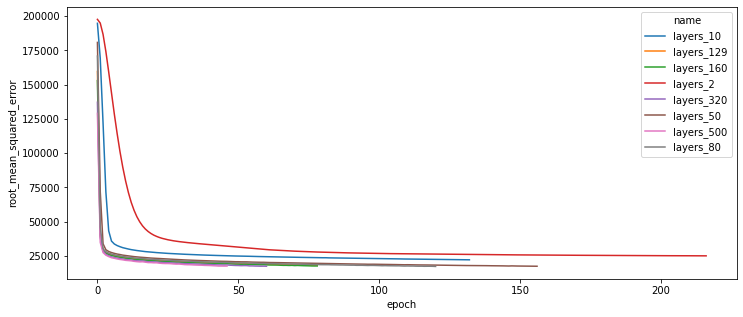

In [21]:
histories_lst=[]
neuron_sizes = [2, 10, 50, 80, 129, 160, 320, 500]
for N in neuron_sizes:
    print('\n')
    print('- '*20+'No. of Neurons: '+str(N)+' -'*15 + '\n')
    estimator = wider_narrower_model(N, dropout = True, rate = 0.1)
    optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + 'wider/' + str(N) + '_dropout.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=32, optimizer = optimizer, patience = 20, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    estimator = wider_narrower_model(N)
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['layers_'+str(N) for N in neuron_sizes])

__dropout rate 0.2__



- - - - - - - - - - - - - - - - - - - - No. of Neurons: 50 - - - - - - - - - - - - - - -

Early Stop Epoch: 122
CV Score: 26273.32 (+/- 90.80)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 80 - - - - - - - - - - - - - - -

Early Stop Epoch: 157
CV Score: 26325.41 (+/- 110.86)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 129 - - - - - - - - - - - - - - -

Early Stop Epoch: 79
CV Score: 26342.47 (+/- 258.92)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 160 - - - - - - - - - - - - - - -

Early Stop Epoch: 95
CV Score: 26247.99 (+/- 147.92)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 320 - - - - - - - - - - - - - - -

Early Stop Epoch: 61
CV Score: 26007.45 (+/- 136.05)


- - - - - - - - - - - - - - - - - - - - No. of Neurons: 500 - - - - - - - - - - - - - - -

Early Stop Epoch: 46
CV Score: 26024.34 (+/- 161.51)


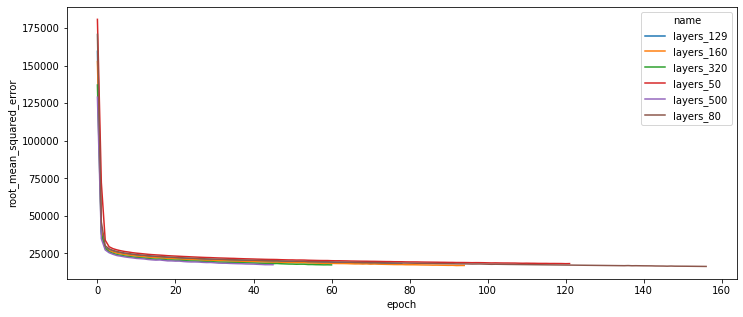

In [22]:
histories_lst=[]
neuron_sizes = [50, 80, 129, 160, 320, 500]
for N in neuron_sizes:
    print('\n')
    print('- '*20+'No. of Neurons: '+str(N)+' -'*15 + '\n')
    estimator = wider_narrower_model(N, dropout = True, rate = 0.2)
    optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + '/wider/' + str(N) + '_dropout.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=32, optimizer = optimizer, patience = 20, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    estimator = wider_narrower_model(N)
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['layers_'+str(N) for N in neuron_sizes])

- 0.2 works better for larger neurons. 320 and 500 have higher cv scores so we will keep these.

### batchsize & learning rate

In [24]:
histories_lst=[]
neuron_sizes = [320, 500]
batchsize = [16, 32]
learningrates = [0.1, 0.05]
for N in neuron_sizes:
    for lr in learningrates:
        for bs in batchsize:
            print('\n')
            print('- '*10+f'No. of Neurons: {N}'+ f' | lr: {lr} | bs: {bs}'+' -'*10 + '\n')
            estimator = wider_narrower_model(N, dropout = True, rate = 0.2)
            optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,amsgrad=False)
            checkpoint_path = CHECKPOINT_PATH + 'wider/' + str(N) + f'_lr{lr}_bs{bs}.h5'
            history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                           batchsize=bs, optimizer = optimizer, patience = 20, 
                                                     checkpoint_path = checkpoint_path)
            best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
            print(f'Early Stop Epoch: {best_epoch}')
            estimator = wider_narrower_model(N)
            histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch, batchsize = bs)



- - - - - - - - - - No. of Neurons: 320 | lr: 0.1 | bs: 16 - - - - - - - - - -

Early Stop Epoch: 25
CV Score: 26357.61 (+/- 251.59)


- - - - - - - - - - No. of Neurons: 320 | lr: 0.1 | bs: 32 - - - - - - - - - -

Early Stop Epoch: 41
CV Score: 25988.54 (+/- 163.97)


- - - - - - - - - - No. of Neurons: 320 | lr: 0.05 | bs: 16 - - - - - - - - - -

Early Stop Epoch: 46
CV Score: 25990.05 (+/- 88.67)


- - - - - - - - - - No. of Neurons: 320 | lr: 0.05 | bs: 32 - - - - - - - - - -

Early Stop Epoch: 61
CV Score: 26007.45 (+/- 136.05)


- - - - - - - - - - No. of Neurons: 500 | lr: 0.1 | bs: 16 - - - - - - - - - -

Early Stop Epoch: 25
CV Score: 26347.78 (+/- 356.64)


- - - - - - - - - - No. of Neurons: 500 | lr: 0.1 | bs: 32 - - - - - - - - - -

Early Stop Epoch: 26
CV Score: 26806.08 (+/- 929.80)


- - - - - - - - - - No. of Neurons: 500 | lr: 0.05 | bs: 16 - - - - - - - - - -

Early Stop Epoch: 41
CV Score: 25843.81 (+/- 101.13)


- - - - - - - - - - No. of Neurons: 500 | lr: 0.05 

__Choose No. of Neurons: 500 | lr: 0.05 | bs: 16__

Finally, try tuning __early stopping__ to see if can get better cross validated score.

In [25]:
N = 500
lr = 0.05
bs = 16
for p in range(10, 60, 10):
    estimator = wider_narrower_model(N, dropout = True, rate = 0.2)
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999,amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + '/wider/' + str(N) + f'_p{p}.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=bs, optimizer = optimizer, patience = p, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    estimator = wider_narrower_model(N)
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch, batchsize = bs)

Early Stop Epoch: 25
CV Score: 26085.49 (+/- 268.62)
Early Stop Epoch: 41
CV Score: 25843.81 (+/- 101.13)
Early Stop Epoch: 41
CV Score: 25847.94 (+/- 99.56)
Early Stop Epoch: 41
CV Score: 25841.27 (+/- 99.96)
Early Stop Epoch: 41
CV Score: 25842.11 (+/- 101.73)


We see that dropout helps larger neural networks improve performance while smaller networks do not benefit from droppouts, which makes sense intuitively.
###### Our best model so far is X->500->Y with dropout rate 0.2

In [26]:
model = load_model('./model_checkpoints/wider/500_p40.h5') # load check point model
optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
histories, cvscores = get_cv_scores(model, optimizer = optimizer, max_epochs = 41, batchsize = 16)
compile_and_fit(model, train_s, train_labels, 41, 16, optimizer)
model.save('./model/model500') # save model

CV Score: 25735.65 (+/- 22.44)
INFO:tensorflow:Assets written to: ./model/model500/assets


So far we've only built simple NN with 1 hidden layer. Let's try deeper NN with more hidden layers to see if they perform better than the simple NN.

## Deeper Models
X -> N -> N -> N -> Y

In [27]:
def deeper_model(L, N, dropout = False, rate = 0.15, batchnorm = False):
#     inputs: 
#         L: integer, number of hidden layers.
#         N: list (integer), list of neurons in each hidden layers. len(N) == L
#         dropout: True or False, model will only drop node in layers where number of neuron is >= 50.
#         rate: float. Dropout rate. ranges between 0 to 1.

    # check inputs
    if len(N) != L:
        raise ValueError('length of N is not equal to L')
        
    set_random_seed(SEED_NUMBER) # reproducibility
    model = keras.Sequential()
    model.add(layers.Dense(N[0], activation='relu', input_shape=[train_s.shape[1],]))
    if dropout:
        if N[0]>=50:
            model.add(layers.Dropout(rate, seed=SEED_NUMBER))
    if batchnorm:
        model.add(layers.BatchNormalization())
    for i in range(1,L): # first layer is already added
        model.add(layers.Dense(N[i], activation='relu'))
        if dropout: 
            if N[i]>=50:
                model.add(layers.Dropout(rate, seed=SEED_NUMBER))
        if batchnorm:
            model.add(layers.BatchNormalization())
    model.add(layers.Dense(1)) # final layer
    # model.summary()

    return model

<b>Try deeper neural net with default settings.



- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 29
CV Score: 26313.37 (+/- 115.98)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 28
CV Score: 26706.98 (+/- 970.70)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [32, 32, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 20
CV Score: 27441.02 (+/- 690.19)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [64, 64, 64] - - - - - - - - - - - - - - -

Early Stop Epoch: 7
CV Score: 28341.16 (+/- 697.93)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [256, 128, 64, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 16
CV Score: 27266.19 (+/- 1882.70)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [10, 10, 10, 10, 10] - - - - - - - - - - - - - - -

Early Stop Epoch: 10
CV Score: 29077.84 (+/- 1860.31)


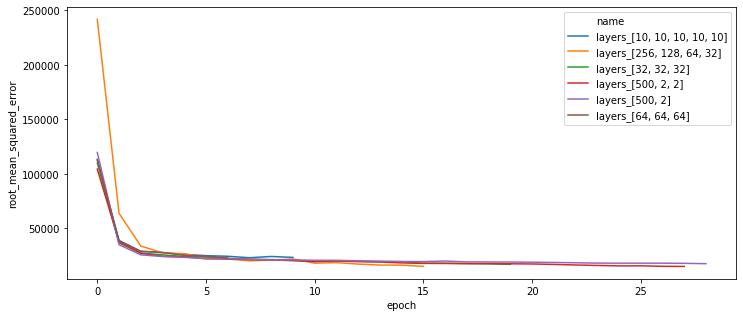

In [28]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32],[10,10,10,10,10]]


lr = 0.05
bs = 32
p = 20
histories_lst = []

for L, N in zip(try_hidden_layers,try_neuron_size):
    print('\n')
    print('- '*20+'Hidden Layers : '+str(N)+' -'*15 + '\n')
    estimator = deeper_model(L, N)
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + 'deeper/' + ''.join([str(i) + '_' for i in N]) + '.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=bs, optimizer = optimizer, 
                                             patience = p, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    
    estimator = deeper_model(L, N) # reinitialize model
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['layers_'+str(N) for N in try_neuron_size])

- deeper neural nets perform worse than shallow neural nets. Let's experiment some regularization and hyper parameter tuning to see if we can improve the performance.

__with Dropout__



- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 28
CV Score: 26466.41 (+/- 537.65)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 19
CV Score: 26431.80 (+/- 650.43)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [32, 32, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 20
CV Score: 27441.02 (+/- 690.19)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [64, 64, 64] - - - - - - - - - - - - - - -

Early Stop Epoch: 11
CV Score: 29275.02 (+/- 2143.19)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [256, 128, 64, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 3
CV Score: 31645.11 (+/- 3854.92)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [10, 10, 10, 10, 10] - - - - - - - - - - - - - - -

Early Stop Epoch: 10
CV Score: 29077.84 (+/- 1860.31)


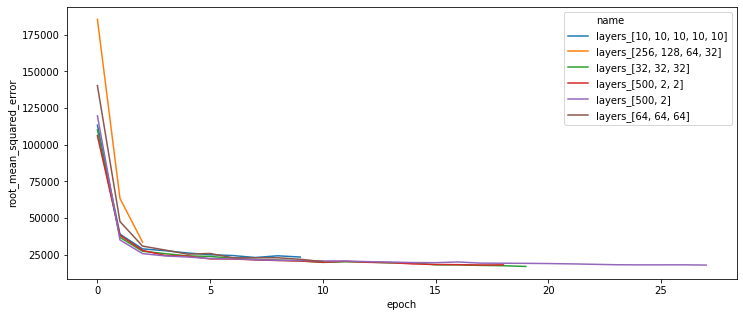

In [29]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32],[10,10,10,10,10]]

lr = 0.05
bs = 32
p = 20
histories_lst = []

for L, N in zip(try_hidden_layers,try_neuron_size):
    print('\n')
    print('- '*20+'Hidden Layers : '+str(N)+' -'*15 + '\n')
    estimator = deeper_model(L, N, dropout = True, rate = 0.2)
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + 'deeper/' + ''.join([str(i) + '_' for i in N]) + '_do.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=bs, optimizer = optimizer, 
                                             patience = p, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    
    estimator = deeper_model(L, N) # reinitialize model
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch, batchsize = bs)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['layers_'+str(N) for N in try_neuron_size])

 - [500,2] [500,2,2]

#### Batchsize & learning rate

In [30]:
try_hidden_layers = [2, 3]
try_neuron_size = [[500,2],[500,2,2]]

batchsize = [16, 32, 64]
learningrates = [0.1, 0.05]


for L, N in zip(try_hidden_layers,try_neuron_size):
    for lr in learningrates:
        for bs in batchsize:
            print('\n')
            print('- '*10+f'Layers: {N}'+ f' | lr: {lr} | bs: {bs}'+' -'*10 + '\n')
            estimator = deeper_model(L, N, dropout = True, rate = 0.2)
            optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
            checkpoint_path = CHECKPOINT_PATH + 'deeper/' + ''.join([str(i) + '_' for i in N]) + f'_lr{lr}_bs{bs}_do.h5'
            history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                           batchsize=bs, optimizer = optimizer, 
                                                     patience = p, checkpoint_path = checkpoint_path)
            best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
            print(f'Early Stop Epoch: {best_epoch}')

            estimator = deeper_model(L, N) # reinitialize model
            histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, 
                                                max_epochs = best_epoch, batchsize = bs)
            



- - - - - - - - - - Layers: [500, 2] | lr: 0.1 | bs: 16 - - - - - - - - - -

Early Stop Epoch: 25
CV Score: 28455.97 (+/- 1050.90)


- - - - - - - - - - Layers: [500, 2] | lr: 0.1 | bs: 32 - - - - - - - - - -

Early Stop Epoch: 19
CV Score: 26499.89 (+/- 564.36)


- - - - - - - - - - Layers: [500, 2] | lr: 0.1 | bs: 64 - - - - - - - - - -

Early Stop Epoch: 33
CV Score: 26518.19 (+/- 404.66)


- - - - - - - - - - Layers: [500, 2] | lr: 0.05 | bs: 16 - - - - - - - - - -

Early Stop Epoch: 25
CV Score: 26328.12 (+/- 431.79)


- - - - - - - - - - Layers: [500, 2] | lr: 0.05 | bs: 32 - - - - - - - - - -

Early Stop Epoch: 28
CV Score: 26466.41 (+/- 537.65)


- - - - - - - - - - Layers: [500, 2] | lr: 0.05 | bs: 64 - - - - - - - - - -

Early Stop Epoch: 55
CV Score: 26380.91 (+/- 457.91)


- - - - - - - - - - Layers: [500, 2, 2] | lr: 0.1 | bs: 16 - - - - - - - - - -

Early Stop Epoch: 14
CV Score: 26729.77 (+/- 933.31)


- - - - - - - - - - Layers: [500, 2, 2] | lr: 0.1 | bs: 32 - - - - 

__Batch Normalization__: normalize the input layer by re-centering and re-scaling.
Batch norm may improve the performance and stability of artificial neural networks. 



- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 74
CV Score: 27365.91 (+/- 252.02)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 177
CV Score: 29358.44 (+/- 572.96)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [32, 32, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 46
CV Score: 28069.88 (+/- 449.01)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [64, 64, 64] - - - - - - - - - - - - - - -

Early Stop Epoch: 23
CV Score: 28295.98 (+/- 1571.23)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [256, 128, 64, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 37
CV Score: 28184.54 (+/- 333.00)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [10, 10, 10, 10, 10] - - - - - - - - - - - - - - -

Early Stop Epoch: 75
CV Score: 29538.90 (+/- 1357.22)


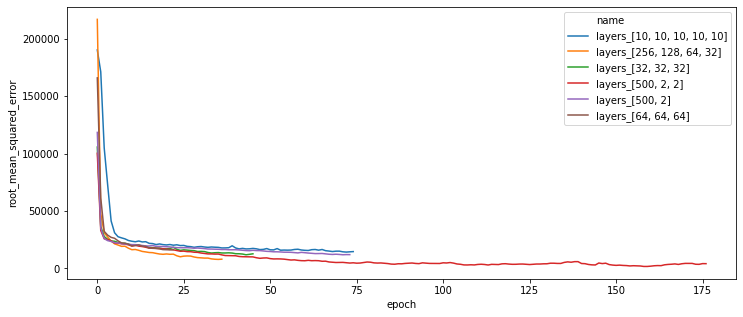

In [31]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32],[10,10,10,10,10]]


lr = 0.05
bs = 32
p = 20
histories_lst = []

for L, N in zip(try_hidden_layers,try_neuron_size):
    print('\n')
    print('- '*20+'Hidden Layers : '+str(N)+' -'*15 + '\n')
    estimator = deeper_model(L, N, batchnorm = True)
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + 'deeper/batchnorm_' + ''.join([str(i) + '_' for i in N]) + '.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=bs, optimizer = optimizer, 
                                             patience = p, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    
    estimator = deeper_model(L, N) # reinitialize model
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['layers_'+str(N) for N in try_neuron_size])

__both dropout and batchnorm__



- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 62
CV Score: 27395.82 (+/- 514.33)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [500, 2, 2] - - - - - - - - - - - - - - -

Early Stop Epoch: 163
CV Score: 29672.05 (+/- 876.76)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [32, 32, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 46
CV Score: 28069.88 (+/- 449.01)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [64, 64, 64] - - - - - - - - - - - - - - -

Early Stop Epoch: 22
CV Score: 28663.97 (+/- 1650.66)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [256, 128, 64, 32] - - - - - - - - - - - - - - -

Early Stop Epoch: 47
CV Score: 28752.98 (+/- 708.38)


- - - - - - - - - - - - - - - - - - - - Hidden Layers : [10, 10, 10, 10, 10] - - - - - - - - - - - - - - -

Early Stop Epoch: 75
CV Score: 29538.90 (+/- 1357.22)


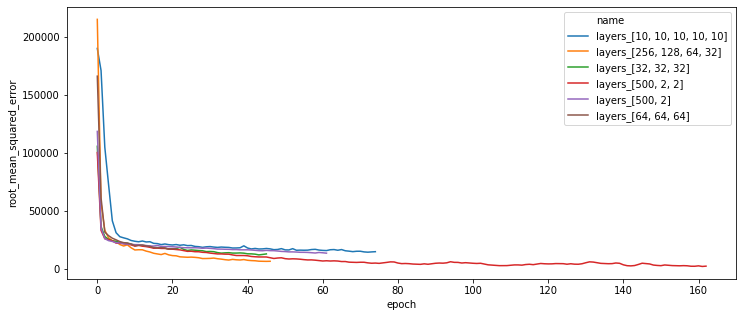

In [32]:
try_hidden_layers = [2, 3, 3, 3, 4, 5]
try_neuron_size = [[500,2],[500,2,2],[32,32,32],[64, 64, 64],[256,128,64,32],[10,10,10,10,10]]


lr = 0.05
bs = 32
p = 20
histories_lst = []

for L, N in zip(try_hidden_layers,try_neuron_size):
    print('\n')
    print('- '*20+'Hidden Layers : '+str(N)+' -'*15 + '\n')
    estimator = deeper_model(L, N, dropout=True, rate = 0.2, batchnorm = True)
    optimizer = keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    checkpoint_path = CHECKPOINT_PATH + 'deeper/reg_' + ''.join([str(i) + '_' for i in N]) + '.h5'
    history = compile_and_fit_early_stopping(estimator, train_s, train_labels, 1000, 
                                   batchsize=bs, optimizer = optimizer, 
                                             patience = p, checkpoint_path = checkpoint_path)
    best_epoch = history.history['val_root_mean_squared_error'].index(min(history.history['val_root_mean_squared_error']))
    print(f'Early Stop Epoch: {best_epoch}')
    
    estimator = deeper_model(L, N) # reinitialize model
    histories, cvscores = get_cv_scores(estimator, optimizer = optimizer, max_epochs = best_epoch)
    histories_lst.append(histories) # nested list
plot_histories_with_names(histories_lst, names = ['layers_'+str(N) for N in try_neuron_size])

From what we've tried, the best deep Neural net: Layers: [500, 2] | lr: 0.05 | bs: 16.
Deeper nets don't necessarily always provide higher performance. 

In [33]:
model = load_model('./model_checkpoints/deeper/500_2__lr0.05_bs16_do.h5') # load best check point model
optimizer = keras.optimizers.Adam(learning_rate=0.05, beta_1=0.9, beta_2=0.999,amsgrad=False)
histories, cvscores = get_cv_scores(model, optimizer = optimizer, max_epochs = 25, batchsize = 16)
compile_and_fit(model, train_s, train_labels, 25, 16, optimizer)
model.save('./model/deeper_500_2') # save model

CV Score: 26213.69 (+/- 231.76)
INFO:tensorflow:Assets written to: ./model/deeper_500_2/assets


### Generate prediction files for kaggle submission

In [34]:
final_predictions={}
best_simple_model = load_model('./model/best_simple_model')
final_predictions['simple_nn'] = best_simple_model.predict(test_s).flatten()
model_500 = load_model('./model/model500')
final_predictions['shallow_500'] =  model_500.predict(test_s).flatten()
deeper_model = load_model('./model/deeper_500_2')
final_predictions['deeper_nn'] =  deeper_model.predict(test_s).flatten()

In [35]:
df = pd.DataFrame.from_dict(final_predictions)
test_raw = pd.read_csv('./data/raw/test.csv')
# pred = pd.DataFrame(final_pred, columns=['SalePrice'])
ID = test_raw[['Id']]
# sub=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
# sub.to_csv('500_2_prediction.csv',index=False)
for i in range(df.shape[1]):
    pred = df.iloc[:,i]
    name = df.columns[i]
    sub=pd.merge(ID, pred, left_on = ID.index, right_on = pred.index).drop(columns=['key_0'])
    sub.columns = ['ID','SalePrice']
    sub.to_csv(name+'_pred.csv', index=False)

### Kaggle Results
|file | datetime | comment | status | result
| --- | --- | --- | --- | --- |
| deeper_nn_pred.csv    |2020-05-12 23:12:35  |deep nn prediction   |complete |  0.14112
| shallow_500_pred.csv  |2020-05-12 21:41:53  |500 neurons          |complete |  0.13924
| simple_nn_pred.csv    |2020-05-12 21:41:24  |basic nn             |complete |  0.14486

- shallow nn with 500 neurons had the highest cv score and highest test score on Kaggle.
- Deeper nn performed better on the 'real world' test set on Kaggle even though its cv score was lower than simple nn.